In [4]:
# Import libraries
import numpy as np
import pandas as pd
import scipy
from scipy import special
from pathlib import Path
import math

from scipy.sparse import csr_matrix

np.random.seed(100)

Nout = 100000  # number of out-of-sample scenarios
Nin = 5000     # number of in-sample scenarios
Ns = 5         # number of idiosyncratic scenarios for each systemic

C = 8          # number of credit states

# Read and parse instrument data
instr_data = np.array(pd.read_csv('instrum_data.csv', header=None))
instr_id = instr_data[:, 0]     # ID
driver = instr_data[:, 1]       # credit driver
beta = instr_data[:, 2]         # beta (sensitivity to credit driver)
recov_rate = instr_data[:, 3]   # expected recovery rate
value = instr_data[:, 4]        # value
prob = instr_data[:, 5:(5 + C)] # credit-state migration probabilities (default to AAA)
exposure = instr_data[:, 5 + C:5 + 2 * C]  # credit-state migration exposures (default to AAA)
retn = instr_data[:, 5 + 2 * C] # market returns

K = instr_data.shape[0]         # number of CPs

# Read matrix of correlations for credit drivers
rho = np.array(pd.read_csv('credit_driver_corr.csv', sep='\t', header=None))
# Cholesky decomp of rho (for generating correlated Normal random numbers)
sqrt_rho = np.linalg.cholesky(rho)

print('======= Credit Risk Model with Credit-State Migrations =======')
print('============== Monte Carlo Scenario Generation ===============')
print(' ')
print(' ')
print(' Number of out-of-sample Monte Carlo scenarios = ' + str(Nout))
print(' Number of in-sample Monte Carlo scenarios = ' + str(Nin))
print(' Number of counterparties = ' + str(K))
print(' ')

# Find credit-state for each counterparty
# 8 = AAA, 7 = AA, 6 = A, 5 = BBB, 4 = BB, 3 = B, 2 = CCC, 1 = default
CS = np.argmax(prob, axis=1) + 1

# Account for default recoveries
exposure[:, 0] = (1 - recov_rate) * exposure[:, 0]

# Compute credit-state boundaries
CS_Bdry = scipy.special.ndtri((np.cumsum(prob[:, 0:C - 1], 1)))

# -------- Insert your code here -------- #
filename_save_out = "Losses_out"
if Path(filename_save_out+'.npz').is_file():
    Losses_out = scipy.sparse.load_npz(filename_save_out + '.npz')
else:
    # Generating Scenarios

    # Loss out of 100,000 scenario 100 counterepaties
    Losses_out = np.zeros((Nout, K))

    # -------- Insert your code here -------- #

    # Generate idiosyncratic component for counterparty k
    Z_idio = np.random.randn(K)

    for s in range(1, Nout + 1):
        # -------- Insert your code here -------- #

        # Generate standard normal systemic risk vector
        Z_sys = np.random.randn(rho.shape[0], 1)

        # Apply Cholesky transformation to induce correlation
        Z_sys_corr = sqrt_rho @ Z_sys

        # Initialize an array to hold losses for all K counterparties in scenario s
        losses_s = []

        for k in range(K):

            # Combine systemic and idiosyncratic risks using beta
            w = beta[k] * Z_sys_corr[int(driver[k]) - 1] + np.sqrt(1 - beta[k]**2) * Z_idio[k]

            # Determine credit state index based on thresholds
            cs = np.searchsorted(CS_Bdry[k, :], w)
            cs = int(min(cs, C - 1))  # cap at max credit state
            losses_s.append(exposure[k, cs])

        # Calculated out-of-sample losses (100000 x 100)
        # Losses_out (sparse matrix)
        # Store this scenario's loss vector into the Losses_out matrix
        Losses_out[s - 1, :] = losses_s

    np.save('Losses_out.npy',Losses_out)


# Normal approximation computed from out-of-sample scenarios
mu_l = np.mean(Losses_out, axis=0).reshape((K))
var_l = np.cov(Losses_out, rowvar=False) # Losses_out as a sparse matrix

# Compute portfolio weights
portf_v = sum(value)  # portfolio value
w0 = []
w0.append(value / portf_v)   # asset weights (portfolio 1)
w0.append(np.ones((K)) / K)  # asset weights (portfolio 2)
x0 = []
x0.append((portf_v / value) * w0[0])  # asset units (portfolio 1)
x0.append((portf_v / value) * w0[1])  # asset units (portfolio 2)

# Quantile levels (99%, 99.9%)
alphas = np.array([0.99, 0.999])

VaRout = np.zeros((2, alphas.size))
VaRinN = np.zeros((2, alphas.size))
CVaRout = np.zeros((2, alphas.size))
CVaRinN = np.zeros((2, alphas.size))

for portN in range(2):
    # Compute VaR and CVaR
    for q in range(alphas.size):
        alf = alphas[q]
        # -------- Insert your code here -------- #

        # Compute portfolio loss from out-of-sample losses
        portf_loss_out = Losses_out @ x0[portN]  # shape: (Nout, )

        # Compute empirical VaR and CVaR from out-of-sample
        VaRout[portN, q] = np.quantile(portf_loss_out, alf)
        CVaRout[portN, q] = portf_loss_out[portf_loss_out >= VaRout[portN, q]].mean()

        # Compute Normal approximation: mean and std dev of portfolio loss
        mu_p = np.dot(mu_l, x0[portN])
        sigma_p = np.sqrt(x0[portN] @ var_l @ x0[portN])

        # Compute VaR and CVaR under Normal approximation
        z_alpha = scipy.stats.norm.ppf(alf)
        VaRinN[portN, q] = mu_p + sigma_p * z_alpha
        CVaRinN[portN, q] = mu_p + sigma_p * scipy.stats.norm.pdf(z_alpha) / (1 - alf)


# Perform 100 trials
N_trials = 100

VaRinMC1 = {}
VaRinMC2 = {}
VaRinN1 = {}
VaRinN2 = {}
CVaRinMC1 = {}
CVaRinMC2 = {}
CVaRinN1 = {}
CVaRinN2 = {}

for portN in range(2):
    for q in range(alphas.size):
        VaRinMC1[portN, q] = np.zeros(N_trials)
        VaRinMC2[portN, q] = np.zeros(N_trials)
        VaRinN1[portN, q] = np.zeros(N_trials)
        VaRinN2[portN, q] = np.zeros(N_trials)
        CVaRinMC1[portN, q] = np.zeros(N_trials)
        CVaRinMC2[portN, q] = np.zeros(N_trials)
        CVaRinN1[portN, q] = np.zeros(N_trials)
        CVaRinN2[portN, q] = np.zeros(N_trials)

Losses_inMC1 = np.zeros((Nin, K))
Losses_inMC2 = np.zeros((Nin, K))

for tr in range(1, N_trials + 1):
    # Monte Carlo approximation 1
    # 1000 systemic scenarios and 5 idiosyncratic scenarios for each systemic

    # -------- Insert your code here -------- #


    for s in range(1, np.int32(np.ceil(Nin / Ns) + 1)): # systemic scenarios
        # -------- Insert your code here -------- #

        for si in range(1, Ns + 1): # idiosyncratic scenarios for each systemic
            # -------- Insert your code here -------- #
            Z_idio = np.random.randn(K)
            idx = (s - 1) * Ns + (si - 1)
            if idx >= Nin:
                break  # safeguard against overflow

            Z_sys = np.random.randn(rho.shape[0])
            Z_sys_corr = sqrt_rho @ Z_sys

            losses_s1 = []

            for k in range(K):
                w1 = beta[k] * Z_sys_corr[int(driver[k]) - 1] + np.sqrt(1 - beta[k]**2) * Z_idio[k]

                cs = np.searchsorted(CS_Bdry[k, :], w1)
                cs = int(min(cs, C - 1))  # cap at max credit state
                losses_s1.append(exposure[k, cs])

            # Calculate losses for MC1 approximation (5000 x 100)
            # Losses_inMC1
            Losses_inMC1[5*(s-1)+si-1] = losses_s1



    # Monte Carlo approximation 2
    # 5000 systemic scenarios and 1 idiosyncratic scenario for each systemic

    # -------- Insert your code here -------- #


    for s in range(1, Nin + 1): # systemic scenarios (1 idiosyncratic scenario for each systemic)
        # -------- Insert your code here -------- #
        Z_idio = np.random.randn(K)
        Z_sys = np.random.randn(rho.shape[0])
        Z_sys_corr = sqrt_rho @ Z_sys

        losses_s2 = []

        for k in range(K):
            w2 = beta[k] * Z_sys_corr[int(driver[k]) - 1] + np.sqrt(1 - beta[k]**2) * Z_idio[k]

            cs = np.searchsorted(CS_Bdry[k, :], w2)
            cs = int(min(cs, C - 1))  # cap at max credit state
            losses_s2.append(exposure[k, cs])

        # Calculated losses for MC2 approximation (5000 x 100)
        # Losses_inMC2
        Losses_inMC2[s - 1, :] = losses_s2


    # Compute VaR and CVaR

    for portN in range(2):
        for q in range(alphas.size):
            alf = alphas[q]
            # -------- Insert your code here -------- #
            # Compute portfolio loss
            portf_loss_inMC1 = np.sort(Losses_inMC1 @ x0[portN])#...
            portf_loss_inMC2 = np.sort(Losses_inMC2 @ x0[portN])#...
            mu_MC1 = np.mean(Losses_inMC1, axis=0).reshape((K))
            var_MC1 = np.cov(Losses_inMC1, rowvar=False)
            mu_MC2 = np.mean(Losses_inMC2, axis=0).reshape((K))
            var_MC2 = np.cov(Losses_inMC2, rowvar=False)
            # Compute portfolio mean loss mu_p_MC1 and portfolio standard deviation of losses sigma_p_MC1
            # Compute portfolio mean loss mu_p_MC2 and portfolio standard deviation of losses sigma_p_MC2
            # Compute VaR and CVaR for the current trial
            mu_p_MC1 = np.mean(portf_loss_inMC1)#...
            sigma_p_MC1 = np.std(portf_loss_inMC1)#...
            mu_p_MC2 = np.mean(portf_loss_inMC2)#...
            sigma_p_MC2 = np.std(portf_loss_inMC2)#...
            VaRinMC1[portN, q][tr - 1] = portf_loss_inMC1[int(math.ceil(Nin * alf)) - 1]#...
            VaRinMC2[portN, q][tr - 1] = portf_loss_inMC2[int(math.ceil(Nin * alf)) - 1]#...

            z_alpha = scipy.stats.norm.ppf(alf)
            VaRinN1[portN, q][tr - 1] =  mu_p_MC1 + sigma_p_MC1 * z_alpha#...
            VaRinN2[portN, q][tr - 1] =  mu_p_MC2 + sigma_p_MC2 * z_alpha#...
            CVaRinMC1[portN, q][tr - 1] = (1/(Nin*(1-alf))) * ((math.ceil(Nin*alf)-Nin*alf)* VaRinMC1[portN, q][tr - 1] + sum(portf_loss_inMC1[int(math.ceil(Nin*alf)):]))#...
            CVaRinMC2[portN, q][tr - 1] = (1/(Nin*(1-alf))) * ((math.ceil(Nin*alf)-Nin*alf)* VaRinMC2[portN, q][tr - 1] + sum(portf_loss_inMC2[int(math.ceil(Nin*alf)):]))#...
            CVaRinN1[portN, q][tr - 1] =  mu_p_MC1 + sigma_p_MC1 * scipy.stats.norm.pdf(z_alpha) / (1 - alf)#...
            CVaRinN2[portN, q][tr - 1] =  mu_p_MC2 + sigma_p_MC2 * scipy.stats.norm.pdf(z_alpha) / (1 - alf)#...

# Display VaR and CVaR

for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('In-sample MC1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC1[portN, q]), 100 * alf, np.mean(CVaRinMC1[portN, q])))
        print('In-sample MC2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC2[portN, q]), 100 * alf, np.mean(CVaRinMC2[portN, q])))
        print('In-sample No: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRinN[portN, q], 100 * alf, CVaRinN[portN, q]))
        print('In-sample N1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinN1[portN, q]), 100 * alf, np.mean(CVaRinN1[portN, q])))
        print('In-sample N2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f\n' % (
        100 * alf, np.mean(VaRinN2[portN, q]), 100 * alf, np.mean(CVaRinN2[portN, q])))

# Plot results (6 plots, 2 portfolios & 3 scenarios)
# Figure (1):
# -------- Insert your code here -------- #
# Figure (2):
# -------- Insert your code here -------- #
# Build tables for errors
# MC  approximations (16 rows)
df_mc = pd.DataFrame({})
# -------- Insert your code here -------- #
# Normal approximations (16 rows)
df_N = pd.DataFrame({})
# -------- Insert your code here -------- #

======= Credit Risk Model with Credit-State Migrations =======
============== Monte Carlo Scenario Generation ===============
 
 
 Number of out-of-sample Monte Carlo scenarios = 100000
 Number of in-sample Monte Carlo scenarios = 5000
 Number of counterparties = 100
 


<ipython-input-4-bff7fe80ced3>:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cs = int(min(cs, C - 1))  # cap at max credit state



Portfolio 1:

Out-of-sample: VaR 99.0% = $16586775.72, CVaR 99.0% = $24924774.02
In-sample MC1: VaR 99.0% = $37157125.00, CVaR 99.0% = $44585575.95
In-sample MC2: VaR 99.0% = $37205997.16, CVaR 99.0% = $44738986.15
In-sample No: VaR 99.0% = $10697314.55, CVaR 99.0% = $11962727.15
In-sample N1: VaR 99.0% = $26169819.11, CVaR 99.0% = $29055129.69
In-sample N2: VaR 99.0% = $26265644.88, CVaR 99.0% = $29162957.82

Out-of-sample: VaR 99.9% = $36324206.11, CVaR 99.9% = $47018608.95
In-sample MC1: VaR 99.9% = $53653413.04, CVaR 99.9% = $60726265.15
In-sample MC2: VaR 99.9% = $53870879.64, CVaR 99.9% = $61910930.15
In-sample No: VaR 99.9% = $13549852.12, CVaR 99.9% = $14583709.02
In-sample N1: VaR 99.9% = $32673987.65, CVaR 99.9% = $35031320.16
In-sample N2: VaR 99.9% = $32796869.59, CVaR 99.9% = $35164008.17


Portfolio 2:

Out-of-sample: VaR 99.0% = $21454034.38, CVaR 99.0% = $31009403.61
In-sample MC1: VaR 99.0% = $27328612.72, CVaR 99.0% = $33370474.01
In-sample MC2: VaR 99.0% = $27384298

In [5]:
VaRout


array([[16586775.71859999, 36324206.11192041],
       [21454034.38126879, 44623790.05855019]])

In [6]:
CVaRout

array([[24924774.01648   , 47018608.95339999],
       [31009403.60924895, 55298156.25067653]])

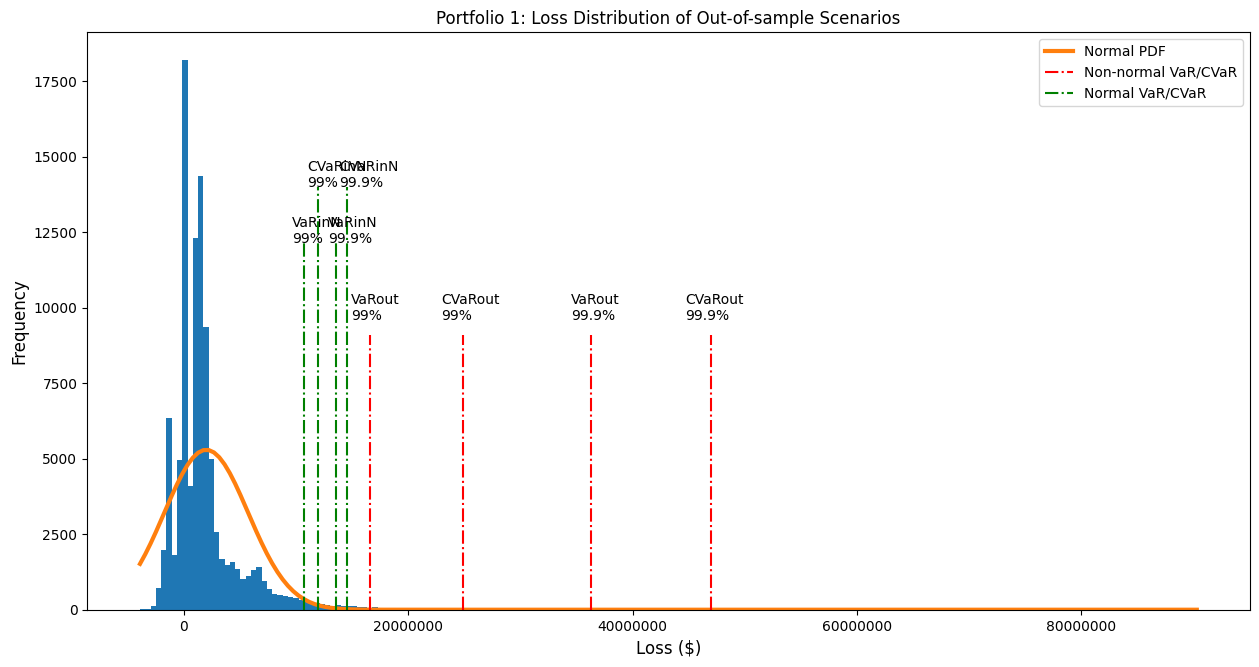

In [7]:
# Plot results
import matplotlib.pyplot as plt
# Loss Distribution of Portfolio 1 Out-of-sample Scenarios
plt.figure(figsize=(15,7.5))
f_count, bins, patch = plt.hist(np.dot(Losses_out,x0[0]), 200)
f_n = (1 / (np.std(np.dot(Losses_out,x0[0])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((bins-np.mean(np.dot(Losses_out,x0[0]))) / np.std(np.dot(Losses_out,x0[0]))) ** 2)
f_n = f_n * sum(f_count) / sum(f_n)
plt.plot(bins, f_n, linewidth=3, label="Normal PDF")

# VaR and CVaR
# Non-normal
plt.plot([VaRout[0,0], VaRout[0,0]], [0, max(f_count)/2], color='r', linestyle='-.', label="Non-normal VaR/CVaR")
plt.text(0.90 * VaRout[0,0], max(f_count) / 1.9, 'VaRout\n99%')
plt.plot([VaRout[0,1], VaRout[0,1]], [0, max(f_count)/2], color='r', linestyle='-.')
plt.text(0.95 * VaRout[0,1], max(f_count) / 1.9, 'VaRout\n99.9%')
plt.plot([CVaRout[0,0], CVaRout[0,0]], [0, max(f_count)/2], color='r', linestyle='-.')
plt.text(0.92 * CVaRout[0,0], max(f_count) / 1.9, 'CVaRout\n99%')
plt.plot([CVaRout[0,1], CVaRout[0,1]], [0, max(f_count)/2], color='r', linestyle='-.')
plt.text(0.95 * CVaRout[0,1], max(f_count) / 1.9, 'CVaRout\n99.9%')

# Normal
plt.plot([VaRinN[0,0], VaRinN[0,0]], [0, max(f_count)/1.5], color='g', linestyle='-.', label="Normal VaR/CVaR")
plt.text(0.90 * VaRinN[0,0], max(f_count) / 1.5, 'VaRinN\n99%')
plt.plot([VaRinN[0,1], VaRinN[0,1]], [0, max(f_count)/1.5], color='g', linestyle='-.')
plt.text(0.95 * VaRinN[0,1], max(f_count) / 1.5, 'VaRinN\n99.9%')
plt.plot([CVaRinN[0,0], CVaRinN[0,0]], [0, max(f_count)/1.3], color='g', linestyle='-.')
plt.text(0.92 * CVaRinN[0,0], max(f_count) / 1.3, 'CVaRinN\n99%')
plt.plot([CVaRinN[0,1], CVaRinN[0,1]], [0, max(f_count)/1.3], color='g', linestyle='-.')
plt.text(0.95 * CVaRinN[0,1], max(f_count) / 1.3, 'CVaRinN\n99.9%')

plt.title('Portfolio 1: Loss Distribution of Out-of-sample Scenarios')
plt.xlabel('Loss ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(loc="upper right")
plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)
plt.show()

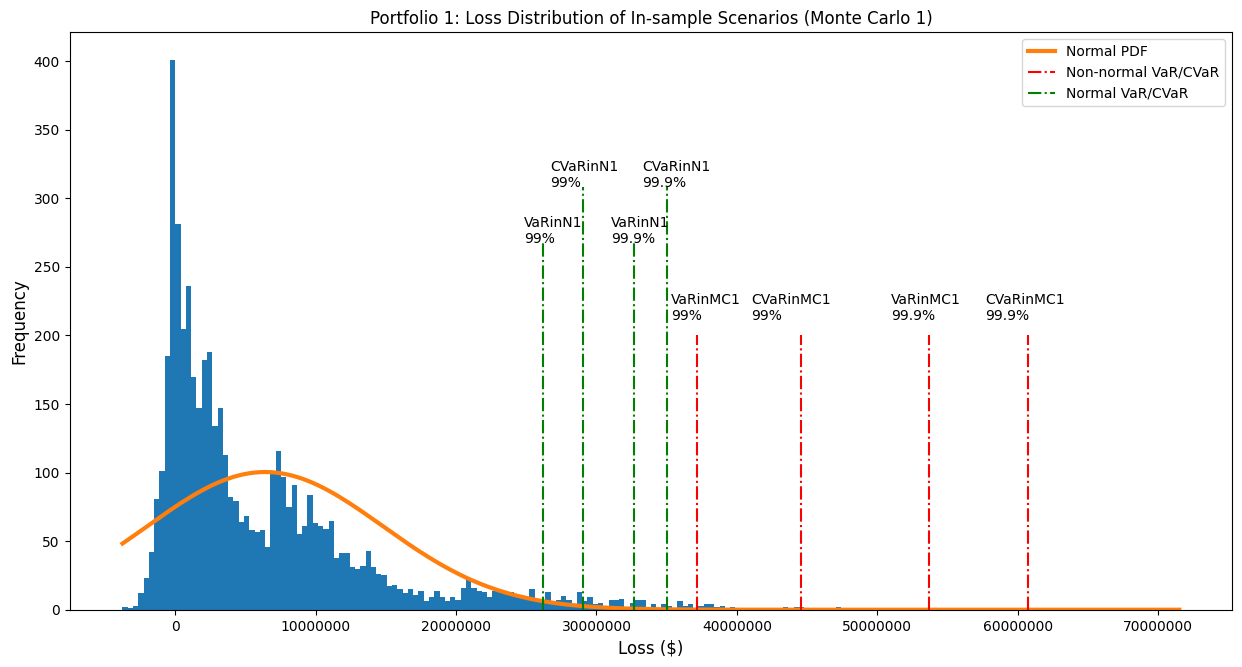

In [8]:
# Loss Distribution of Portfolio 1 In-sample Scenarios (Monte Carlo 1)
plt.figure(figsize=(15,7.5))
f_count, bins, patch = plt.hist(np.dot(Losses_inMC1,x0[0]), 200)
f_n = (1 / (np.std(np.dot(Losses_inMC1,x0[0])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((bins-np.mean(np.dot(Losses_inMC1,x0[0]))) / np.std(np.dot(Losses_inMC1,x0[0]))) ** 2)
f_n = f_n * sum(f_count) / sum(f_n)
plt.plot(bins, f_n, linewidth=3, label="Normal PDF")

# VaR and CVaR
# Non-normal
plt.plot([np.mean(VaRinMC1[0, 0]), np.mean(VaRinMC1[0, 0])], [0, max(f_count)/2], color='r', linestyle='-.', label="Non-normal VaR/CVaR")
plt.text(0.95 * np.mean(VaRinMC1[0, 0]), max(f_count) / 1.9, 'VaRinMC1\n99%')
plt.plot([np.mean(VaRinMC1[0, 1]), np.mean(VaRinMC1[0, 1])], [0, max(f_count)/2], color='r', linestyle='-.')
plt.text(0.95 * np.mean(VaRinMC1[0, 1]), max(f_count) / 1.9, 'VaRinMC1\n99.9%')
plt.plot([np.mean(CVaRinMC1[0, 0]), np.mean(CVaRinMC1[0, 0])], [0, max(f_count)/2], color='r', linestyle='-.')
plt.text(0.92 * np.mean(CVaRinMC1[0, 0]), max(f_count) / 1.9, 'CVaRinMC1\n99%')
plt.plot([np.mean(CVaRinMC1[0, 1]), np.mean(CVaRinMC1[0, 1])], [0, max(f_count)/2], color='r', linestyle='-.')
plt.text(0.95 * np.mean(CVaRinMC1[0, 1]), max(f_count) / 1.9, 'CVaRinMC1\n99.9%')

# Normal
plt.plot([np.mean(VaRinN1[0, 0]), np.mean(VaRinN1[0, 0])], [0, max(f_count)/1.5], color='g', linestyle='-.', label="Normal VaR/CVaR")
plt.text(0.95 * np.mean(VaRinN1[0, 0]), max(f_count) / 1.5, 'VaRinN1\n99%')
plt.plot([np.mean(VaRinN1[0, 1]), np.mean(VaRinN1[0, 1])], [0, max(f_count)/1.5], color='g', linestyle='-.')
plt.text(0.95 * np.mean(VaRinN1[0, 1]), max(f_count) / 1.5, 'VaRinN1\n99.9%')
plt.plot([np.mean(CVaRinN1[0, 0]), np.mean(CVaRinN1[0, 0])], [0, max(f_count)/1.3], color='g', linestyle='-.')
plt.text(0.92 * np.mean(CVaRinN1[0, 0]), max(f_count) / 1.3, 'CVaRinN1\n99%')
plt.plot([np.mean(CVaRinN1[0, 1]), np.mean(CVaRinN1[0, 1])], [0, max(f_count)/1.3], color='g', linestyle='-.')
plt.text(0.95 * np.mean(CVaRinN1[0, 1]), max(f_count) / 1.3, 'CVaRinN1\n99.9%')

plt.title('Portfolio 1: Loss Distribution of In-sample Scenarios (Monte Carlo 1)')
plt.xlabel('Loss ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(loc="upper right")
plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)
plt.show()

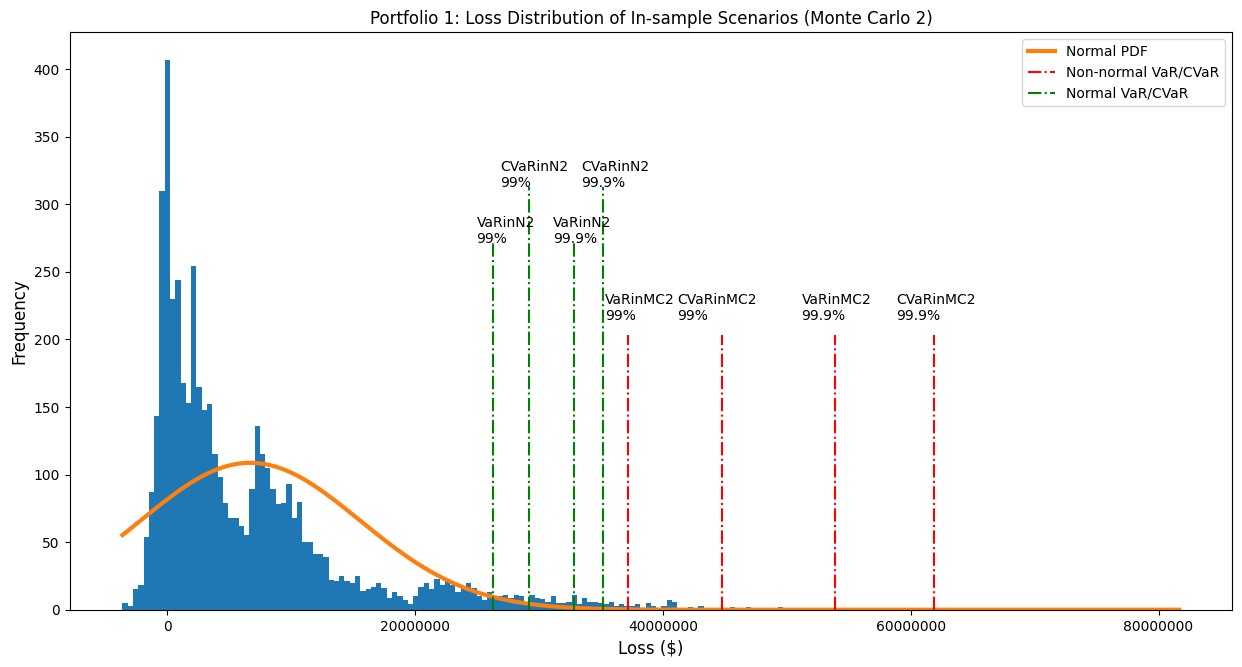

In [9]:
# Loss Distribution of Portfolio 1 In-sample Scenarios (Monte Carlo 2)
plt.figure(figsize=(15,7.5))
f_count, bins, patch = plt.hist(np.dot(Losses_inMC2,x0[0]), 200)
f_n = (1 / (np.std(np.dot(Losses_inMC2,x0[0])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((bins-np.mean(np.dot(Losses_inMC2,x0[0]))) / np.std(np.dot(Losses_inMC2,x0[0]))) ** 2)
f_n = f_n * sum(f_count) / sum(f_n)
plt.plot(bins, f_n, linewidth=3, label="Normal PDF")

# VaR and CVaR
# Non-normal
plt.plot([np.mean(VaRinMC2[0, 0]), np.mean(VaRinMC2[0, 0])], [0, max(f_count)/2], color='r', linestyle='-.', label="Non-normal VaR/CVaR")
plt.text(0.95 * np.mean(VaRinMC2[0, 0]), max(f_count) / 1.9, 'VaRinMC2\n99%')
plt.plot([np.mean(VaRinMC2[0, 1]), np.mean(VaRinMC2[0, 1])], [0, max(f_count)/2], color='r', linestyle='-.')
plt.text(0.95 * np.mean(VaRinMC2[0, 1]), max(f_count) / 1.9, 'VaRinMC2\n99.9%')
plt.plot([np.mean(CVaRinMC2[0, 0]), np.mean(CVaRinMC2[0, 0])], [0, max(f_count)/2], color='r', linestyle='-.')
plt.text(0.92 * np.mean(CVaRinMC2[0, 0]), max(f_count) / 1.9, 'CVaRinMC2\n99%')
plt.plot([np.mean(CVaRinMC2[0, 1]), np.mean(CVaRinMC2[0, 1])], [0, max(f_count)/2], color='r', linestyle='-.')
plt.text(0.95 * np.mean(CVaRinMC2[0, 1]), max(f_count) / 1.9, 'CVaRinMC2\n99.9%')

# Normal
plt.plot([np.mean(VaRinN2[0, 0]), np.mean(VaRinN2[0, 0])], [0, max(f_count)/1.5], color='g', linestyle='-.', label="Normal VaR/CVaR")
plt.text(0.95 * np.mean(VaRinN2[0, 0]), max(f_count) / 1.5, 'VaRinN2\n99%')
plt.plot([np.mean(VaRinN2[0, 1]), np.mean(VaRinN2[0, 1])], [0, max(f_count)/1.5], color='g', linestyle='-.')
plt.text(0.95 * np.mean(VaRinN2[0, 1]), max(f_count) / 1.5, 'VaRinN2\n99.9%')
plt.plot([np.mean(CVaRinN2[0, 0]), np.mean(CVaRinN2[0, 0])], [0, max(f_count)/1.3], color='g', linestyle='-.')
plt.text(0.92 * np.mean(CVaRinN2[0, 0]), max(f_count) / 1.3, 'CVaRinN2\n99%')
plt.plot([np.mean(CVaRinN2[0, 1]), np.mean(CVaRinN2[0, 1])], [0, max(f_count)/1.3], color='g', linestyle='-.')
plt.text(0.95 * np.mean(CVaRinN2[0, 1]), max(f_count) / 1.3, 'CVaRinN2\n99.9%')

plt.title('Portfolio 1: Loss Distribution of In-sample Scenarios (Monte Carlo 2)')
plt.xlabel('Loss ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(loc="upper right")
plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)
plt.show()

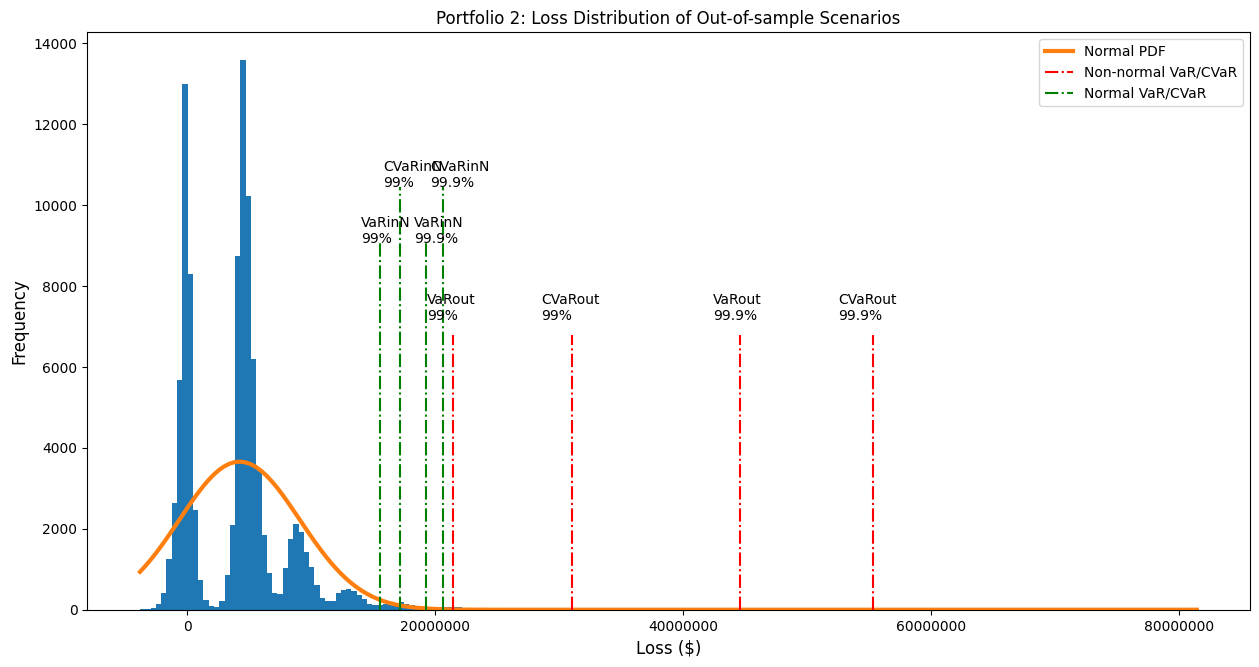

In [10]:
# Plot results

# Loss Distribution of Portfolio 2 Out-of-sample Scenarios
plt.figure(figsize=(15,7.5))
f_count, bins, patch = plt.hist(np.dot(Losses_out,x0[1]), 200)
f_n = (1 / (np.std(np.dot(Losses_out,x0[1])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((bins-np.mean(np.dot(Losses_out,x0[1]))) / np.std(np.dot(Losses_out,x0[1]))) ** 2)
f_n = f_n * sum(f_count) / sum(f_n)
plt.plot(bins, f_n, linewidth=3, label="Normal PDF")

# VaR and CVaR
# Non-normal
plt.plot([VaRout[1,0], VaRout[1,0]], [0, max(f_count)/2], color='r', linestyle='-.', label="Non-normal VaR/CVaR")
plt.text(0.90 * VaRout[1,0], max(f_count) / 1.9, 'VaRout\n99%')
plt.plot([VaRout[1,1], VaRout[1,1]], [0, max(f_count)/2], color='r', linestyle='-.')
plt.text(0.95 * VaRout[1,1], max(f_count) / 1.9, 'VaRout\n99.9%')
plt.plot([CVaRout[1,0], CVaRout[1,0]], [0, max(f_count)/2], color='r', linestyle='-.')
plt.text(0.92 * CVaRout[1,0], max(f_count) / 1.9, 'CVaRout\n99%')
plt.plot([CVaRout[1,1], CVaRout[1,1]], [0, max(f_count)/2], color='r', linestyle='-.')
plt.text(0.95 * CVaRout[1,1], max(f_count) / 1.9, 'CVaRout\n99.9%')

# Normal
plt.plot([VaRinN[1,0], VaRinN[1,0]], [0, max(f_count)/1.5], color='g', linestyle='-.', label="Normal VaR/CVaR")
plt.text(0.90 * VaRinN[1,0], max(f_count) / 1.5, 'VaRinN\n99%')
plt.plot([VaRinN[1,1], VaRinN[1,1]], [0, max(f_count)/1.5], color='g', linestyle='-.')
plt.text(0.95 * VaRinN[1,1], max(f_count) / 1.5, 'VaRinN\n99.9%')
plt.plot([CVaRinN[1,0], CVaRinN[1,0]], [0, max(f_count)/1.3], color='g', linestyle='-.')
plt.text(0.92 * CVaRinN[1,0], max(f_count) / 1.3, 'CVaRinN\n99%')
plt.plot([CVaRinN[1,1], CVaRinN[1,1]], [0, max(f_count)/1.3], color='g', linestyle='-.')
plt.text(0.95 * CVaRinN[1,1], max(f_count) / 1.3, 'CVaRinN\n99.9%')

plt.title('Portfolio 2: Loss Distribution of Out-of-sample Scenarios')
plt.xlabel('Loss ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(loc="upper right")
plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)
plt.show()

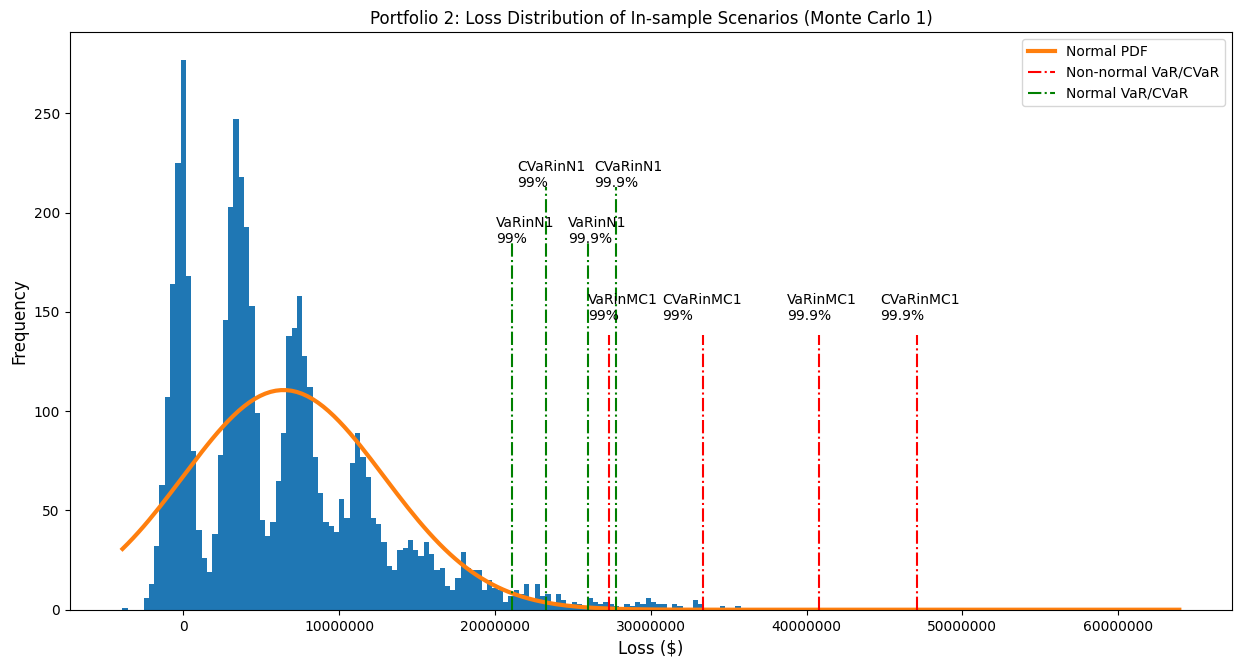

In [11]:
# Loss Distribution of Portfolio 2 In-sample Scenarios (Monte Carlo 1)
plt.figure(figsize=(15,7.5))
f_count, bins, patch = plt.hist(np.dot(Losses_inMC1,x0[1]), 200)
f_n = (1 / (np.std(np.dot(Losses_inMC1,x0[1])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((bins-np.mean(np.dot(Losses_inMC1,x0[1]))) / np.std(np.dot(Losses_inMC1,x0[1]))) ** 2)
f_n = f_n * sum(f_count) / sum(f_n)
plt.plot(bins, f_n, linewidth=3, label="Normal PDF")

# VaR and CVaR
# Non-normal
plt.plot([np.mean(VaRinMC1[1, 0]), np.mean(VaRinMC1[1, 0])], [0, max(f_count)/2], color='r', linestyle='-.', label="Non-normal VaR/CVaR")
plt.text(0.95 * np.mean(VaRinMC1[1, 0]), max(f_count) / 1.9, 'VaRinMC1\n99%')
plt.plot([np.mean(VaRinMC1[1, 1]), np.mean(VaRinMC1[1, 1])], [0, max(f_count)/2], color='r', linestyle='-.')
plt.text(0.95 * np.mean(VaRinMC1[1, 1]), max(f_count) / 1.9, 'VaRinMC1\n99.9%')
plt.plot([np.mean(CVaRinMC1[1, 0]), np.mean(CVaRinMC1[1, 0])], [0, max(f_count)/2], color='r', linestyle='-.')
plt.text(0.92 * np.mean(CVaRinMC1[1, 0]), max(f_count) / 1.9, 'CVaRinMC1\n99%')
plt.plot([np.mean(CVaRinMC1[1, 1]), np.mean(CVaRinMC1[1, 1])], [0, max(f_count)/2], color='r', linestyle='-.')
plt.text(0.95 * np.mean(CVaRinMC1[1, 1]), max(f_count) / 1.9, 'CVaRinMC1\n99.9%')

# Normal
plt.plot([np.mean(VaRinN1[1, 0]), np.mean(VaRinN1[1, 0])], [0, max(f_count)/1.5], color='g', linestyle='-.', label="Normal VaR/CVaR")
plt.text(0.95 * np.mean(VaRinN1[1, 0]), max(f_count) / 1.5, 'VaRinN1\n99%')
plt.plot([np.mean(VaRinN1[1, 1]), np.mean(VaRinN1[1, 1])], [0, max(f_count)/1.5], color='g', linestyle='-.')
plt.text(0.95 * np.mean(VaRinN1[1, 1]), max(f_count) / 1.5, 'VaRinN1\n99.9%')
plt.plot([np.mean(CVaRinN1[1, 0]), np.mean(CVaRinN1[1, 0])], [0, max(f_count)/1.3], color='g', linestyle='-.')
plt.text(0.92 * np.mean(CVaRinN1[1, 0]), max(f_count) / 1.3, 'CVaRinN1\n99%')
plt.plot([np.mean(CVaRinN1[1, 1]), np.mean(CVaRinN1[1, 1])], [0, max(f_count)/1.3], color='g', linestyle='-.')
plt.text(0.95 * np.mean(CVaRinN1[1, 1]), max(f_count) / 1.3, 'CVaRinN1\n99.9%')

plt.title('Portfolio 2: Loss Distribution of In-sample Scenarios (Monte Carlo 1)')
plt.xlabel('Loss ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(loc="upper right")
plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)
plt.show()

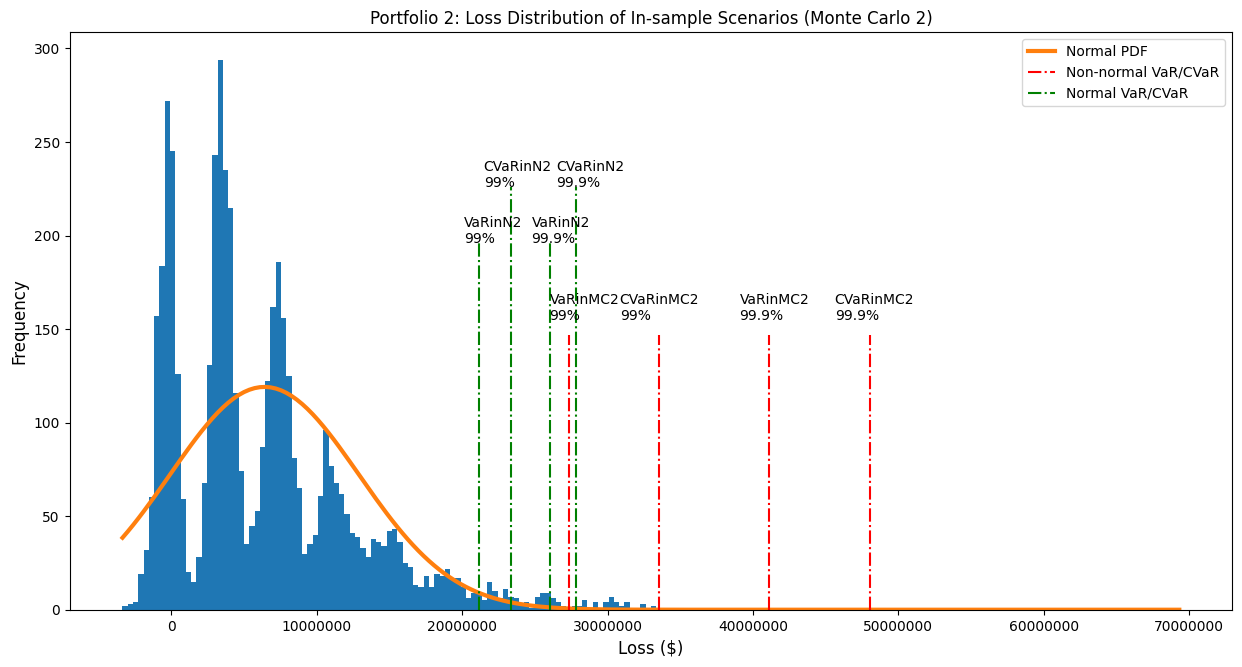

In [12]:
# Loss Distribution of Portfolio 2 In-sample Scenarios (Monte Carlo 2)
plt.figure(figsize=(15,7.5))
f_count, bins, patch = plt.hist(np.dot(Losses_inMC2,x0[1]), 200)
f_n = (1 / (np.std(np.dot(Losses_inMC2,x0[1])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((bins-np.mean(np.dot(Losses_inMC2,x0[1]))) / np.std(np.dot(Losses_inMC2,x0[1]))) ** 2)
f_n = f_n * sum(f_count) / sum(f_n)
plt.plot(bins, f_n, linewidth=3, label="Normal PDF")

# VaR and CVaR
# Non-normal
plt.plot([np.mean(VaRinMC2[1, 0]), np.mean(VaRinMC2[1, 0])], [0, max(f_count)/2], color='r', linestyle='-.', label="Non-normal VaR/CVaR")
plt.text(0.95 * np.mean(VaRinMC2[1, 0]), max(f_count) / 1.9, 'VaRinMC2\n99%')
plt.plot([np.mean(VaRinMC2[1, 1]), np.mean(VaRinMC2[1, 1])], [0, max(f_count)/2], color='r', linestyle='-.')
plt.text(0.95 * np.mean(VaRinMC2[1, 1]), max(f_count) / 1.9, 'VaRinMC2\n99.9%')
plt.plot([np.mean(CVaRinMC2[1, 0]), np.mean(CVaRinMC2[1, 0])], [0, max(f_count)/2], color='r', linestyle='-.')
plt.text(0.92 * np.mean(CVaRinMC2[1, 0]), max(f_count) / 1.9, 'CVaRinMC2\n99%')
plt.plot([np.mean(CVaRinMC2[1, 1]), np.mean(CVaRinMC2[1, 1])], [0, max(f_count)/2], color='r', linestyle='-.')
plt.text(0.95 * np.mean(CVaRinMC2[1, 1]), max(f_count) / 1.9, 'CVaRinMC2\n99.9%')

# Normal
plt.plot([np.mean(VaRinN2[1, 0]), np.mean(VaRinN2[1, 0])], [0, max(f_count)/1.5], color='g', linestyle='-.', label="Normal VaR/CVaR")
plt.text(0.95 * np.mean(VaRinN2[1, 0]), max(f_count) / 1.5, 'VaRinN2\n99%')
plt.plot([np.mean(VaRinN2[1, 1]), np.mean(VaRinN2[1, 1])], [0, max(f_count)/1.5], color='g', linestyle='-.')
plt.text(0.95 * np.mean(VaRinN2[1, 1]), max(f_count) / 1.5, 'VaRinN2\n99.9%')
plt.plot([np.mean(CVaRinN2[1, 0]), np.mean(CVaRinN2[1, 0])], [0, max(f_count)/1.3], color='g', linestyle='-.')
plt.text(0.92 * np.mean(CVaRinN2[1, 0]), max(f_count) / 1.3, 'CVaRinN2\n99%')
plt.plot([np.mean(CVaRinN2[1, 1]), np.mean(CVaRinN2[1, 1])], [0, max(f_count)/1.3], color='g', linestyle='-.')
plt.text(0.95 * np.mean(CVaRinN2[1, 1]), max(f_count) / 1.3, 'CVaRinN2\n99.9%')

plt.title('Portfolio 2: Loss Distribution of In-sample Scenarios (Monte Carlo 2)')
plt.xlabel('Loss ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(loc="upper right")
plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)
plt.show()

In [13]:
# Sampling error

pd.reset_option('^display.', silent=True)
df1 = pd.DataFrame(columns=['In-sample value','True distribution value','Sampling Error (% difference)'])

# Portfolio 1

# 99%
df1.loc['99% VaR, MC1, Portfolio 1'] = [np.mean(VaRinMC1[0, 0]),VaRout[0, 0],(np.mean(VaRinMC1[0, 0])-VaRout[0, 0])/VaRout[0, 0]*100]
df1.loc['99% CVaR, MC1, Portfolio 1'] = [np.mean(CVaRinMC1[0, 0]),CVaRout[0, 0],(np.mean(CVaRinMC1[0, 0])-CVaRout[0, 0])/VaRout[0, 0]*100]
df1.loc['99% VaR, MC2, Portfolio 1'] = [np.mean(VaRinMC2[0, 0]),VaRout[0, 0],(np.mean(VaRinMC2[0, 0])-VaRout[0, 0])/VaRout[0, 0]*100]
df1.loc['99% CVaR, MC2, Portfolio 1'] = [np.mean(CVaRinMC2[0, 0]),CVaRout[0, 0],(np.mean(CVaRinMC2[0, 0])-CVaRout[0, 0])/VaRout[0, 0]*100]

# 99.9%
df1.loc['99.9% VaR, MC1, Portfolio 1'] = [np.mean(VaRinMC1[0, 1]),VaRout[0, 1],(np.mean(VaRinMC1[0, 1])-VaRout[0, 1])/VaRout[0, 1]*100]
df1.loc['99.9% CVaR, MC1, Portfolio 1'] = [np.mean(CVaRinMC1[0, 1]),CVaRout[0, 1],(np.mean(CVaRinMC1[0, 1])-CVaRout[0, 1])/VaRout[0, 1]*100]
df1.loc['99.9% VaR, MC2, Portfolio 1'] = [np.mean(VaRinMC2[0, 1]),VaRout[0, 1],(np.mean(VaRinMC2[0, 1])-VaRout[0, 1])/VaRout[0, 1]*100]
df1.loc['99.9% CVaR, MC2, Portfolio 1'] = [np.mean(CVaRinMC2[0, 1]),CVaRout[0, 1],(np.mean(CVaRinMC2[0, 1])-CVaRout[0, 1])/VaRout[0, 1]*100]

# Portfolio 2

# 99%
df1.loc['99% VaR, MC1, Portfolio 2'] = [np.mean(VaRinMC1[1, 0]),VaRout[1, 0],(np.mean(VaRinMC1[1, 0])-VaRout[1, 0])/VaRout[1, 0]*100]
df1.loc['99% CVaR, MC1, Portfolio 2'] = [np.mean(CVaRinMC1[1, 0]),CVaRout[1, 0],(np.mean(CVaRinMC1[1, 0])-CVaRout[1, 0])/VaRout[1, 0]*100]
df1.loc['99% VaR, MC2, Portfolio 2'] = [np.mean(VaRinMC2[1, 0]),VaRout[1, 0],(np.mean(VaRinMC2[1, 0])-VaRout[1, 0])/VaRout[1, 0]*100]
df1.loc['99% CVaR, MC2, Portfolio 2'] = [np.mean(CVaRinMC2[1, 0]),CVaRout[1, 0],(np.mean(CVaRinMC2[1, 0])-CVaRout[1, 0])/VaRout[1, 0]*100]

# 99.9%
df1.loc['99.9% VaR, MC1, Portfolio 2'] = [np.mean(VaRinMC1[1, 1]),VaRout[1, 1],(np.mean(VaRinMC1[1, 1])-VaRout[1, 1])/VaRout[1, 1]*100]
df1.loc['99.9% CVaR, MC1, Portfolio 2'] = [np.mean(CVaRinMC1[1, 1]),CVaRout[1, 1],(np.mean(CVaRinMC1[1, 1])-CVaRout[1, 1])/VaRout[1, 1]*100]
df1.loc['99.9% VaR, MC2, Portfolio 2'] = [np.mean(VaRinMC2[1, 1]),VaRout[1, 1],(np.mean(VaRinMC2[1, 1])-VaRout[1, 1])/VaRout[1, 1]*100]
df1.loc['99.9% CVaR, MC2, Portfolio 2'] = [np.mean(CVaRinMC2[1, 1]),CVaRout[1, 1],(np.mean(CVaRinMC2[1, 1])-CVaRout[1, 1])/VaRout[1, 1]*100]

# Generate table
df1['In-sample value'] = df1['In-sample value'].map('${:,.2f}'.format)
df1['True distribution value'] = df1['True distribution value'].map('${:,.2f}'.format)
df1['Sampling Error (% difference)'] = df1['Sampling Error (% difference)'].map("{:,.2f}%".format)
df1

,In-sample value,True distribution value,Sampling Error (% difference)
"99% VaR, MC1, Portfolio 1","$37,157,125.00","$16,586,775.72",124.02%
"99% CVaR, MC1, Portfolio 1","$44,585,575.95","$24,924,774.02",118.53%
"99% VaR, MC2, Portfolio 1","$37,205,997.16","$16,586,775.72",124.31%
"99% CVaR, MC2, Portfolio 1","$44,738,986.15","$24,924,774.02",119.46%
"99.9% VaR, MC1, Portfolio 1","$53,653,413.04","$36,324,206.11",47.71%
"99.9% CVaR, MC1, Portfolio 1","$60,726,265.15","$47,018,608.95",37.74%
"99.9% VaR, MC2, Portfolio 1","$53,870,879.64","$36,324,206.11",48.31%
"99.9% CVaR, MC2, Portfolio 1","$61,910,930.15","$47,018,608.95",41.00%
"99% VaR, MC1, Portfolio 2","$27,328,612.72","$21,454,034.38",27.38%
"99% CVaR, MC1, Portfolio 2","$33,370,474.01","$31,009,403.61",11.01%


In [14]:
# Model error

df2 = pd.DataFrame(columns=['Normal model value','True distribution value','Model Error (% difference)'])

# Portfolio 1

# 99%
df2.loc['99% VaR, N1, Portfolio 1'] = [np.mean(VaRinN1[0, 0]),VaRout[0, 0],(np.mean(VaRinN1[0, 0])-VaRout[0, 0])/VaRout[0, 0]*100]
df2.loc['99% CVaR, N1, Portfolio 1'] = [np.mean(CVaRinN1[0, 0]),CVaRout[0, 0],(np.mean(CVaRinN1[0, 0])-CVaRout[0, 0])/VaRout[0, 0]*100]
df2.loc['99% VaR, N2, Portfolio 1'] = [np.mean(VaRinN2[0, 0]),VaRout[0, 0],(np.mean(VaRinN2[0, 0])-VaRout[0, 0])/VaRout[0, 0]*100]
df2.loc['99% CVaR, N2, Portfolio 1'] = [np.mean(CVaRinN2[0, 0]),CVaRout[0, 0],(np.mean(CVaRinN2[0, 0])-CVaRout[0, 0])/VaRout[0, 0]*100]

# 99.9%
df2.loc['99.9% VaR, N1, Portfolio 1'] = [np.mean(VaRinN1[0, 1]),VaRout[0, 1],(np.mean(VaRinN1[0, 1])-VaRout[0, 1])/VaRout[0, 1]*100]
df2.loc['99.9% CVaR, N1, Portfolio 1'] = [np.mean(CVaRinN1[0, 1]),CVaRout[0, 1],(np.mean(CVaRinN1[0, 1])-CVaRout[0, 1])/VaRout[0, 1]*100]
df2.loc['99.9% VaR, N2, Portfolio 1'] = [np.mean(VaRinN2[0, 1]),VaRout[0, 1],(np.mean(VaRinN2[0, 1])-VaRout[0, 1])/VaRout[0, 1]*100]
df2.loc['99.9% CVaR, N2, Portfolio 1'] = [np.mean(CVaRinN2[0, 1]),CVaRout[0, 1],(np.mean(CVaRinN2[0, 1])-CVaRout[0, 1])/VaRout[0, 1]*100]

# Portfolio 2

# 99%
df2.loc['99% VaR, N1, Portfolio 2'] = [np.mean(VaRinN1[1, 0]),VaRout[1, 0],(np.mean(VaRinN1[1, 0])-VaRout[1, 0])/VaRout[1, 0]*100]
df2.loc['99% CVaR, N1, Portfolio 2'] = [np.mean(CVaRinN1[1, 0]),CVaRout[1, 0],(np.mean(CVaRinN1[1, 0])-CVaRout[1, 0])/VaRout[1, 0]*100]
df2.loc['99% VaR, N2, Portfolio 2'] = [np.mean(VaRinN2[1, 0]),VaRout[1, 0],(np.mean(VaRinN2[1, 0])-VaRout[1, 0])/VaRout[1, 0]*100]
df2.loc['99% CVaR, N2, Portfolio 2'] = [np.mean(CVaRinN2[1, 0]),CVaRout[1, 0],(np.mean(CVaRinN2[1, 0])-CVaRout[1, 0])/VaRout[1, 0]*100]

# 99.9%
df2.loc['99.9% VaR, N1, Portfolio 2'] = [np.mean(VaRinN1[1, 1]),VaRout[1, 1],(np.mean(VaRinN1[1, 1])-VaRout[1, 1])/VaRout[1, 1]*100]
df2.loc['99.9% CVaR, N1, Portfolio 2'] = [np.mean(CVaRinN1[1, 1]),CVaRout[1, 1],(np.mean(CVaRinN1[1, 1])-CVaRout[1, 1])/VaRout[1, 1]*100]
df2.loc['99.9% VaR, N2, Portfolio 2'] = [np.mean(VaRinN2[1, 1]),VaRout[1, 1],(np.mean(VaRinN2[1, 1])-VaRout[1, 1])/VaRout[1, 1]*100]
df2.loc['99.9% CVaR, N2, Portfolio 2'] = [np.mean(CVaRinN2[1, 1]),CVaRout[1, 1],(np.mean(CVaRinN2[1, 1])-CVaRout[1, 1])/VaRout[1, 1]*100]

# Generate table
df2['Normal model value'] = df2['Normal model value'].map('${:,.2f}'.format)
df2['True distribution value'] = df2['True distribution value'].map('${:,.2f}'.format)
df2['Model Error (% difference)'] = df2['Model Error (% difference)'].map("{:,.2f}%".format)
df2

,Normal model value,True distribution value,Model Error (% difference)
"99% VaR, N1, Portfolio 1","$26,169,819.11","$16,586,775.72",57.78%
"99% CVaR, N1, Portfolio 1","$29,055,129.69","$24,924,774.02",24.90%
"99% VaR, N2, Portfolio 1","$26,265,644.88","$16,586,775.72",58.35%
"99% CVaR, N2, Portfolio 1","$29,162,957.82","$24,924,774.02",25.55%
"99.9% VaR, N1, Portfolio 1","$32,673,987.65","$36,324,206.11",-10.05%
"99.9% CVaR, N1, Portfolio 1","$35,031,320.16","$47,018,608.95",-33.00%
"99.9% VaR, N2, Portfolio 1","$32,796,869.59","$36,324,206.11",-9.71%
"99.9% CVaR, N2, Portfolio 1","$35,164,008.17","$47,018,608.95",-32.64%
"99% VaR, N1, Portfolio 2","$21,109,302.85","$21,454,034.38",-1.61%
"99% CVaR, N1, Portfolio 2","$23,275,103.97","$31,009,403.61",-36.05%


In [19]:
# compute mean loss and standard deviation of losses for each corporate bond from the 3 scenario sets (N=1000×5, 5000, 100000).

# portfolio 1
# out of sample
mo_1 = np.mean(sorted(np.dot(Losses_out,x0[0])))
so_1 = np.std(sorted(np.dot(Losses_out,x0[0])))
# in-sample MC1
mmc1_1 = np.dot(mu_MC1,x0[0])
smc1_1 = np.std(sorted(np.dot(Losses_inMC1,x0[0])))
# in-sample MC2
mmc2_1 = np.dot(mu_MC2,x0[0])
smc2_1 = np.std(sorted(np.dot(Losses_inMC2,x0[0])))

# portfolio 2
# out of sample
mo_2 = np.mean(sorted(np.dot(Losses_out,x0[1])))
so_2 = np.std(sorted(np.dot(Losses_out,x0[1])))
# mean and standard deviation of in-sample MC1
mmc1_2 = np.dot(mu_MC1,x0[1])
smc1_2 = np.std(sorted(np.dot(Losses_inMC1,x0[1])))
# mean and standard deviation of in-sample MC2
mmc2_2 = np.dot(mu_MC2,x0[1])
smc2_2 = np.std(sorted(np.dot(Losses_inMC2,x0[1])))

# plot
pd.options.display.float_format = '${:,.2f}'.format
pd.DataFrame([[mo_1, so_1], [mmc1_1,smc1_1], [mmc2_1,smc2_1],[mo_2, so_2], [mmc1_2,smc1_2],[mmc2_2,smc2_2]],
             index = ['Out of sample, Portfolio 1','MC1, Portfolio 1','MC2, Portfolio 1','Out-of-sample, Portfolio 2','MC1, Portfolio 2','MC2Portfolio 2',],
             columns = ['Mean','Standard Deviation'])

,Mean,Standard Deviation
"Out of sample, Portfolio 1","$2,010,143.53","$3,734,234.11"
"MC1, Portfolio 1","$6,410,275.18","$8,386,405.34"
"MC2, Portfolio 1","$6,696,558.92","$8,865,993.64"
"Out-of-sample, Portfolio 2","$4,216,482.87","$4,866,142.65"
"MC1, Portfolio 2","$6,421,765.88","$6,447,904.82"
MC2Portfolio 2,"$6,410,945.89","$6,493,104.97"
